# Analyse des données du PIM

## Extraction des données

### Préambule technique

In [1]:
# setting up sys.path for relative imports
from pathlib import Path
import sys
project_root = str(Path(sys.path[0]).parents[1].absolute())
if project_root not in sys.path:
    sys.path.append(project_root)

In [2]:
# imports and customization of diplay
import io
import pandas as pd
pd.options.display.min_rows = 6
pd.options.display.width=108
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from src.pimapi import Requester

### Récupération des données

Le requêtage des données dans le PIM s'appuie sur la classe `Requester` du module pimapi.

In [5]:
requester = Requester('prd')
# Let's fetch the full content of PIM system
requester.fetch_all_from_PIM()
requester.result

Done


[<Response [200]>,
 <Response [200]>,
 <Response [200]>,
 <Response [200]>,
 <Response [200]>,
 <Response [200]>,
 <Response [200]>,
 <Response [200]>,
 <Response [200]>,
 <Response [200]>,
 <Response [200]>,
 <Response [200]>,
 <Response [200]>,
 <Response [200]>]

A ce stade, les données sont chargées en mémoire sous la forme de fichiers JSON. La conversion des données récupérées par l'API se fait via la méthode `result_to_dataframe` de la classe `Requester`.

In [6]:
df = requester.result_to_dataframe()
df.head(4)

,entity-type,repository,path,type,state,parentRef,isCheckedOut,isVersion,isProxy,changeToken,...,properties.pprodqmdd:manufacturingDiagram.length,properties.pprodqmdd:manufacturingDiagram.data,properties.pprodq:visualPhoto.name,properties.pprodq:visualPhoto.mime-type,properties.pprodq:visualPhoto.encoding,properties.pprodq:visualPhoto.digestAlgorithm,properties.pprodq:visualPhoto.digest,properties.pprodq:visualPhoto.length,properties.pprodq:visualPhoto.data,properties.notif:notifications
uid,,,,,,,,,,,,,,,,,,,,,
afee12c7-177e-4a68-9539-8cbb68442503,document,default,/default-domain/pomSupplierWorkspace/SICO/DEST...,pomProduct,product.waiting.supplier.validation,a58845c0-cab3-492f-b48d-531f146c3777,True,False,False,17-0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7d390121-17e8-43bf-a357-9d06b79d2d47,document,default,/default-domain/pomSupplierWorkspace/UNILEVER_...,pomProduct,product.waiting.supplier.validation,a37abc27-f485-4ae9-921b-f761f16c8c1c,False,False,False,15-0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
f234cd84-c8f6-433f-85ec-6e0b6980adc6,document,default,/default-domain/pomSupplierWorkspace/AZTECA_FO...,pomProduct,product.waiting.supplier.validation,3ff7819a-a392-493f-beb8-0b323ac331c7,True,False,False,33-0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
e82a8173-b379-41ac-b319-aa058a04fcfb,document,default,/default-domain/pomSupplierWorkspace/UVCDR_-_C...,pomProduct,product.waiting.sending.supplier,e4b5167c-ece2-4f7a-83c1-fb884034a1bf,False,False,False,19-0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Définitions pour les mises en formes

### Descriptifs longs

On définit un dictionnaire permettant de "traduire" les codes de champs en libellés long.

In [7]:
lab = {
    'code': 'Code produit', 
    'supplier': 'Code fournisseur',
    'type': 'Type de produit',
    'GTIN': 'GTIN',
    'base_unit': 'Unité de base', 
    'net_weight': 'Poids net',
    'gross_weight': 'Poids brut', 
    'dry_weight': 'Poids net égoutté',
    'volume': 'Volume',
    'total_life': 'Durée de vie totale',
    'remaining_life': 'Durée minimale restante',
    'type_cons': 'Type de conservation',
    'before_open': 'Conservation avant ouv.',
    'after_open': 'Convervation après ouv.',
    'cons_temp': 'Température',   
}

### Champs interessants

On liste également les champs intéressants pour un affichage plus court du dataframe.

In [8]:
def_fields = {'properties.vig:code': 'code',
              'properties.psec:supplierCode': 'supplier',
              'properties.pprodtop:typeOfProduct': 'type',
              'properties.pprodi:gtin': 'gtin',
              'properties.pprodi:supplierDesignation': 'designation'}


## Description des attributs des produit

### Volumétrie des attributs

On constate que chaque produit porte un très grand nombre d'attributs : 

In [9]:
print('Count of columns in df:', len(df.columns))
print('\nInfo of df:')
df.info()

Count of columns in df: 487

Info of df:
<class 'pandas.core.frame.DataFrame'>
Index: 13193 entries, afee12c7-177e-4a68-9539-8cbb68442503 to 6dfce29e-fd4c-4670-9f9c-5c02a5b4d52a
Columns: 487 entries, entity-type to properties.notif:notifications
dtypes: bool(12), float64(60), int64(2), object(413)
memory usage: 48.1+ MB


De plus, de par la nature hiérarchique du format JSON, certains attributs dits "multivalués" sont parfois stockés sous forme de liste dans le dataframe "à plat".
Par exemple, on peut voir que le pays de transformation, ou les facettes, peuvent être multivalués.

In [10]:
df.loc[['609af223-2f14-4f83-a553-cef276f2eca7',
        'c94013e4-0dca-441a-85c1-0b29ecb54d0a',
        '82d1af25-2bdd-4315-9670-67784b70dfa7'],
       ['properties.pprodg:transfoCountries',
        'facets']]

,properties.pprodg:transfoCountries,facets
uid,,
609af223-2f14-4f83-a553-cef276f2eca7,"[PL, FR, ES]","[Versionable, Folderish, Commentable, beginnin..."
c94013e4-0dca-441a-85c1-0b29ecb54d0a,"[DE, NO, BE, RU, CH, BG, LT, GR, FR, UA, HU, E...","[endMigration, Versionable, Folderish, Comment..."
82d1af25-2bdd-4315-9670-67784b70dfa7,[FR],"[endMigration, Versionable, Folderish, Comment..."


De plus, certains attributs sont dits "complexes", car chacune des valeurs de la liste est elle-même un dictionnaire d'attribut.
La combinaison des deux, des attributs "complexes multivalués" existe également. On a alors une liste de dictionnaires. On peut comme ceci imbriquer des niveaux jusqu'à n'importe quelle profondeur.

C'est par exemple le cas des labels qui sont multivalués (un produit peut porter plusieurs labels), qui sont des complexes portant :
- le type de label (bio, Label Rouge, ...)
- la date de fin de validité du label (si applicable)
- le fichier de certification du label (si applicable), qui est lui-même un complexe...


In [11]:
multilabel_ds = df.loc[df['properties.pprodl:labels'].apply(len) > 1, 'properties.pprodl:labels']
for uid, label_list in multilabel_ds.head(3).iteritems():
    print('product uid:', uid)
    for cpt, label in enumerate(label_list):
        print('\n\tlabel', cpt + 1, ':')
        for key, val in label.items():
            print('\t\t', key, ':', val)
    print('-------------------------------------')    

product uid: 362e6230-ba3a-4396-8a47-728b0a1d56db

	label 1 :
		 labelCertificateEndDate : 2024-12-30T23:00:00.000Z
		 typeOfLabel : 80
		 labelCertificateFile : {'name': 'KCC Coleshill Tissue Paper Ecolabel Renewal Certificate Mar 2020.pdf', 'mime-type': 'application/pdf', 'encoding': None, 'digestAlgorithm': 'MD5', 'digest': '6615e3027ff2e014fdc3fa37e67851bb', 'length': '425662', 'data': 'https://produits.groupe-pomona.fr/nuxeo/nxfile/default/362e6230-ba3a-4396-8a47-728b0a1d56db/pprodl:labels/0/labelCertificateFile/KCC%20Coleshill%20Tissue%20Paper%20Ecolabel%20Renewal%20Certificate%20Mar%202020.pdf?changeToken=36-0'}

	label 2 :
		 labelCertificateEndDate : 2022-09-16T22:00:00.000Z
		 typeOfLabel : NA
		 labelCertificateFile : {'name': 'FCC_DoC_Coleshill Mill_PW_blue_Ref13351_Eng V01.pdf', 'mime-type': 'application/pdf', 'encoding': None, 'digestAlgorithm': 'MD5', 'digest': '78cfcc67b8bf0f693e060088f7d97c48', 'length': '84473', 'data': 'https://produits.groupe-pomona.fr/nuxeo/nxfile/

### Description des principaux attributs

On commence par déclarer des utilitaires permettant de mettre en forme les représentations.

In [12]:
# Defining main data to explore
mappings = {
    'identification': {
      'properties.vig:code': 'code',
      'properties.psec:supplierCode': 'supplier',
      'properties.pprodtop:typeOfProduct': 'type',
      'properties.pprodi:gtin': 'GTIN',
    },
    'dimensions': {
        'properties.pprodtop:baseUnit': 'base_unit',
        'properties.pprodg:netWeight': 'net_weight',
        'properties.pprodg:grossWeight': 'gross_weight',
        'properties.pprodg:dryWeight': 'dry_weight',
        'properties.pprodg:volume': 'volume',
    },
    'conservation': {
        'properties.pprodg:totalLife': 'total_life',
        'properties.pprodg:guaranteedLife': 'remaining_life',
        'properties.pprodq:typeOfConservation': 'type_cons',
        'properties.pprodq:conservationBeforeOpening': 'before_open',
        'properties.pprodq:conservationAfterOpening': 'after_open',
        'properties.pprodq:conservationTemperature': 'cons_temp',
    }
  }

# Helper function to transform pandas `to_latex` method output to a tabularx env instead.
def to_tabularx(stringio):
    text = stringio.getvalue()
    text = text.replace(r'\begin{tabular}', r'\begin{tabularx}{\linewidth}')
    text = text.replace(r'\end{tabular}',r'\end{tabularx}')
    return(text)

# Function that saves dataframe as Latex tabularx files as input
def save_to_disk(df, path, lab=lab, tex_label=None):
    text = io.StringIO()
    c_format = 'l' + 'X' * len(df.columns)
    (df.rename(lab, axis=1)
       .to_latex(text,
                 bold_rows=True,
                 column_format=c_format,
                 na_rep='-',
                 label=tex_label,
                 ))    
    with open(path, mode='w') as file:
        file.write(to_tabularx(text))    

On boucle sur les différents mappings, et on les sauvegardes dans des tableaux latex pour intégration au rapport.

In [13]:
for map_type, mapping in mappings.items():
    cur_df = df.loc[:, list(mapping.keys())].rename(mapping, axis=1).fillna(np.nan)
    desc = cur_df.describe(include='all')
    samp = cur_df.sample(n=5, random_state=42)
    print(map_type)
    print(samp.rename(lab, axis=1))
    print('---------------------------------------------------')
    print(desc.rename(lab, axis=1)
              .round(3)
         )
    print('---------------------------------------------------')
    
    # Writing dataframes to .tex files
    text = io.StringIO()
    c_format = 'l' + 'X' * len(cur_df.columns)
    (samp.rename(lab, axis=1)
         .to_latex(text,
                   bold_rows=True,
                   column_format=c_format,
                   na_rep='-'
                   ))
    with open(Path('..') / 'tbls' / ('Exemple '+ map_type +'.tex'), mode='w') as file:
        file.write(to_tabularx(text))

    text = io.StringIO()    
    (desc.rename(lab, axis=1)
         .round(3)
         .to_latex(text,
                   bold_rows=True,
                   column_format=c_format,
                   na_rep='-'
                   ))
    with open(Path('..') / 'tbls' / ('Desc '+ map_type +'.tex'), mode='w') as file:
        file.write(to_tabularx(text))
    

identification
                                         Code produit Code fournisseur Type de produit           GTIN
uid                                                                                                  
1351c135-0d48-41ae-a568-2f33af6fdae9  PIMP-0000011253  PIMF-0000000416         grocery  3760063337099
ffabf67f-314e-47a8-932e-37da7a3ab1ae  PIMP-0000011972  PIMF-0000000486         hygiene            NaN
7bb3d9a9-d50c-4042-9d28-21b31f5cbbb1  PIMP-0000009973  PIMF-0000000328  alcoholicDrink            NaN
38b95b6e-5603-46bd-ad44-912a926ee0e4  PIMP-0000012507  PIMF-0000000391       chemistry  7615400045495
8738c768-9d5d-4233-b54c-99358fa66411  PIMP-0000000321  PIMF-0000000074         hygiene  3504082216054
---------------------------------------------------
           Code produit Code fournisseur Type de produit   GTIN
count             13193            13193           13193  12025
unique            13193              605               5  11339
top     PIMP-0000000721  PI

### Analyses spécifiques : GTIN

On peut mettre en évidence les produits qui portent les mêmes GTIN en double. En y jetant un oeil rapide, quelques explications peuvent être trouvées : 
- il peut s'agir d'un changement de code fournisseur (les 2 premières lignes ne portent pas le même code fournisseur)
- il peut s'agir d'un changement de recette côté industriel, qui a décidé de conserver le même GTIN (second couple)
- il peut s'agir d'une erreur, et de produits en doublon dans le système (troisième couple)
- ...

In [14]:
GTIN_mask = (df['properties.pprodi:gtin'] != '') & ~(pd.isna(df['properties.pprodi:gtin']))
dups_mask = df.loc[GTIN_mask, 'properties.pprodi:gtin'].duplicated(keep=False)
examples = (df.loc[GTIN_mask & dups_mask, def_fields.keys()]
              .rename(def_fields, axis=1)
              .sort_values('gtin')
              .head(8))
save_to_disk(examples,
             Path('..') / 'tbls' / 'Duplicated_GTIN.tex',
             lab={},
             tex_label='tab:dup_gtin',
            )
print(examples)

                                                 code         supplier     type            gtin  \
uid                                                                                               
048712e3-f145-4f40-b8ad-7c0b912983bd  PIMP-0000009515  PIMF-0000000420  grocery   0020176760607   
4de8ce87-8df5-440c-959d-3d77d59bb4f3  PIMP-0000013159  PIMF-0000000182  grocery   0020176760607   
7e455046-def3-4526-a28b-bc5c0e6e64fc  PIMP-0000011456  PIMF-0000000290  grocery  03344540125906   
a92c6ac5-d5be-4f92-98b3-9f6c588f7613  PIMP-0000013198  PIMF-0000000290  grocery  03344540125906   
66590f04-5eae-4829-b0da-c899a18dd9cb  PIMP-0000010839  PIMF-0000000250  grocery   3011360083845   
27e20042-dc53-46b4-874c-f970db554aec  PIMP-0000001494  PIMF-0000000250  grocery   3011360083845   
02803e27-487a-43e3-9324-9ad1660b63b2  PIMP-0000002338  PIMF-0000000348  grocery   3038353024906   
52d3f309-e402-4931-974c-b6b6fa721aff  PIMP-0000002337  PIMF-0000000348  grocery   3038353024906   

         

Si l'on produit la répartition du nombre de produit portant un GTIN donné dans le système, on obtient :

                     Nb de GTIN
Pdt portant le GTIN            
1                         11068
2                           227
3                            22
4                            20
5                             1


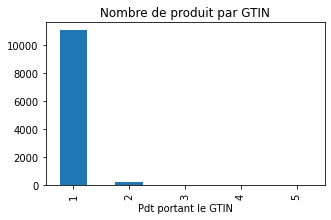

In [15]:
df2 = (df.pivot_table(values='properties.vig:code',
                      index='properties.pprodi:gtin',
                      aggfunc='count')
        .rename({'properties.vig:code': 'code_count'}, axis=1)
      )

df2 = (df2.reset_index()
          .loc[df2.index != '']
          .pivot_table(index='code_count',
                       aggfunc='count',
                       values='code_count')
          .rename({'properties.pprodi:gtin': 'Nb de GTIN'},
                  axis=1)
)

df2.index.rename('Pdt portant le GTIN', inplace=True)

print(df2)

save_to_disk(df2,
             Path('..') / 'tbls' / 'gtin_counts.tex')

fig, ax = plt.subplots(figsize=(5,3))
df2.plot(kind='bar', legend=None, title='Nombre de produit par GTIN', ax=ax)
fig.savefig(Path('..') / 'img' / 'repartition_gtin.png', bbox_inches='tight')

### Analyse spécifique : distribution par fournisseur

On peut représenter la distribution produit, par fournisseur.

In [16]:
# construction the counts
counts = (df.loc[:, list(def_fields.keys())]
            .rename(def_fields, axis=1)
            .pivot_table(values='code',
                         index='supplier',
                         aggfunc='count')
            .reset_index()
            .pivot_table(values=['supplier', 'code'],
                         index='code',
                         aggfunc={'supplier': 'count',
                         'code': 'sum'})
)

# aligning index to have it countinuous
new_idx = pd.RangeIndex(start=1, stop=max(counts.index) + 1)

counts = (counts.reindex(new_idx)
                .fillna(0)
)

counts = pd.concat([counts,
                    counts.cumsum().rename({'code': 'cum_code', 'supplier': 'cum_supplier'},
                                           axis=1),
                   ],
                   axis=1)

for feature in ['supplier', 'code']:
    counts['cump_' + feature] = 100 * counts['cum_' + feature] / counts.loc[:, 'cum_' + feature].iloc[-1]

counts

,code,supplier,cum_code,cum_supplier,cump_supplier,cump_code
1,79.0,79.0,79.0,79.0,13.057851,0.598802
2,138.0,69.0,217.0,148.0,24.462810,1.644812
3,177.0,59.0,394.0,207.0,34.214876,2.986432
...,...,...,...,...,...,...
368,0.0,0.0,12454.0,603.0,99.669421,94.398545
369,369.0,1.0,12823.0,604.0,99.834711,97.195482
370,370.0,1.0,13193.0,605.0,100.000000,100.000000


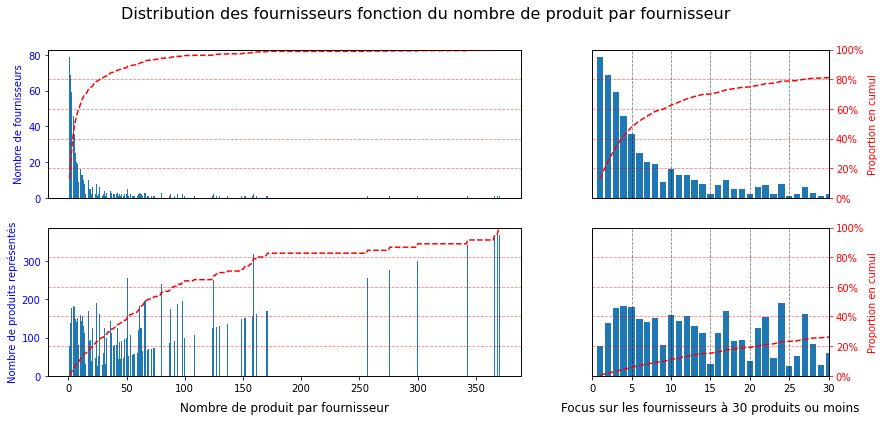

In [17]:
fig, axs = plt.subplots(nrows=2,
                        ncols=2,
                        figsize=(14, 6),
                        gridspec_kw= {'width_ratios': [2, 1]})

axs2 = [[ax.twinx() for ax in axrow] for axrow in axs]

for i, feature in enumerate(['supplier', 'code']):
    axs[i][0].bar(data=counts.loc[:, feature].reset_index(), x='index', height=feature)
    axs2[i][0].plot('index', 'cump_' + feature, data=counts.loc[:, 'cump_' + feature].reset_index(),
                    color='red', linestyle='--')
    axs2[i][0].grid(True, axis='y', color='red', alpha=0.5, linestyle='--')
    
    axs[i][1].bar(data=counts.loc[:, feature].reset_index(), x='index', height=feature)
    axs2[i][1].plot('index', 'cump_' + feature, data=counts.loc[:, 'cump_' + feature].reset_index(),
                    color='red', linestyle='--')
    axs2[i][1].grid(True, axis='y', color='red', alpha=0.5, linestyle='--')
    
    axs[i][1].set_xlim(0, 30)
    
for i in range(len(axs)):
    for j in range(len(axs[i])):
        axs2[i][j].set_ylim(0, 100)
        # remove all bottom ticks except for bottom line
        # set_yticks does not work as it removes the grid
        if i < len(axs) - 1:
            axs[i][j].set_xticklabels([])
            for tic in axs[i][j].xaxis.get_major_ticks():
                tic.tick1line.set_visible(False)
                tic.tick2line.set_visible(False)
        # remove all right ticks except for right column
        # set_yticks does not work as it removes the grid
        if j < len(axs[i]) - 1: 
            axs2[i][j].set_yticklabels([])
            for tic in axs2[i][j].yaxis.get_major_ticks():
                tic.tick1line.set_visible(False)
                tic.tick2line.set_visible(False)
        # remove all left ticks except for first column
        if j > 0: 
            axs[i][j].set_yticks([])
        if j == len(axs[i]) - 1:
            axs2[i][j].tick_params(axis='y', colors='red')
            axs2[i][j].yaxis.set_major_formatter(ticker.PercentFormatter())
            axs2[i][j].set_ylabel('Proportion en cumul', color='red')
            axs[i][j].grid(True, axis='x', color='k', alpha=0.5, linestyle='--')
        if j == 0:
            axs[i][j].tick_params(axis='y', colors='blue')
            if i == 0: 
                axs[i][j].set_ylabel('Nombre de fournisseurs', color='blue')
            if i == 1:
                axs[i][j].set_ylabel('Nombre de produits représentés', color='blue')
axs[1][0].set_xlabel('Nombre de produit par fournisseur', 
                     fontsize=12,
                     labelpad=8,
                    )
axs[1][1].set_xlabel('Focus sur les fournisseurs à 30 produits ou moins', 
                     fontsize=12,
                     labelpad=8,
                    )

fig.suptitle('Distribution des fournisseurs fonction du nombre de produit par fournisseur',
             fontsize=16,
            )

fig.savefig(Path('..') / 'img' / 'distribution_fournisseurs_par_prd_count.png', bbox_inches='tight')

On peut également représenter le nombre de produits "récupérés" si on prend les fournisseurs par nombre de produits décroissant.

In [18]:
# construction the counts
counts = (df.loc[:, list(def_fields.keys())]
            .rename(def_fields, axis=1)
            .pivot_table(values='code',
                         index='supplier',
                         aggfunc='count')
            .sort_values('code', ascending=False)
)
counts['code_cumsum'] = counts['code'].cumsum()
counts

,code,code_cumsum
supplier,,
PIMF-0000000179,370,370
PIMF-0000000250,369,739
PIMF-0000000283,366,1105
...,...,...
PIMF-0000000408,1,13191
PIMF-0000000407,1,13192
PIMF-0000000666,1,13193


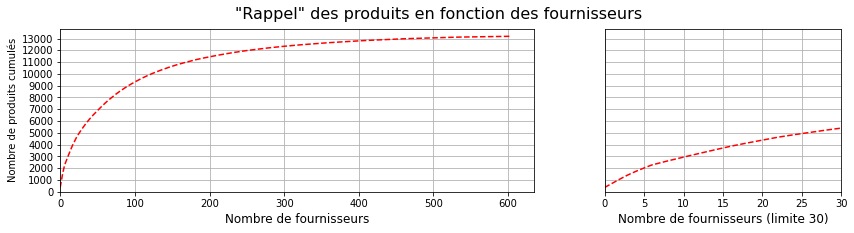

In [19]:
fig, axs = plt.subplots(nrows=1,
                        ncols=2,
                        figsize=(14, 3),
                        gridspec_kw= {'width_ratios': [2, 1]})

for j in range(len(axs)):
    axs[j].plot('index',
                'code_cumsum',
                data=counts.reset_index().reset_index(),
                color='red',
                linestyle='--',
               )
    axs[j].set_xlabel('Nombre de fournisseurs', fontsize=12)
    axs[j].set_ylim(0)
    axs[j].set_xlim(0)
    axs[j].grid(True)
    axs[j].yaxis.set_ticks(np.arange(0, 14000, 1000))

axs[0].set_ylabel('Nombre de produits cumulés')
axs[1].set_xlim(0, 30)
axs[1].set_xlabel('Nombre de fournisseurs (limite 30)', fontsize=12)
axs[1].set_yticklabels([])
for tic in axs[1].yaxis.get_major_ticks():
    tic.tick1line.set_visible(False)
    tic.tick2line.set_visible(False)

fig.suptitle('"Rappel" des produits en fonction des fournisseurs', fontsize=16)

fig.savefig(Path('..') / 'img' / 'rappel_produit_par_fournisseur.png', bbox_inches='tight')